# 2. Pré-processamento dos Dados

In [60]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from geopy.distance import geodesic
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

In [61]:
orders = pd.read_csv('../datasets/datasets-originais/olist_orders_dataset.csv')
orders_items = pd.read_csv('../datasets/datasets-originais/olist_order_items_dataset.csv')
customers = pd.read_csv('../datasets/datasets-originais/olist_customers_dataset.csv')
sellers = pd.read_csv('../datasets/datasets-originais/olist_sellers_dataset.csv')
products = pd.read_csv('../datasets/datasets-originais/olist_products_dataset.csv')
geolocation = pd.read_csv('../datasets/datasets-originais/olist_geolocation_dataset.csv')

In [62]:
geolocation['geolocation_zip_code_prefix'] = geolocation['geolocation_zip_code_prefix'].astype(str)
customers['customer_zip_code_prefix'] = customers['customer_zip_code_prefix'].astype(str)
sellers['seller_zip_code_prefix'] = sellers['seller_zip_code_prefix'].astype(str)

df = pd.merge(orders, orders_items, on='order_id', how='left')

df_geo_agg = geolocation.groupby('geolocation_zip_code_prefix').agg(
    geo_lat=('geolocation_lat', 'mean'),
    geo_lng=('geolocation_lng', 'mean')
).reset_index()

df = pd.merge(orders, customers, on='customer_id', how='left')
df = pd.merge(df, orders_items, on='order_id', how='left')
df = pd.merge(df, sellers, on='seller_id', how='left')
df = pd.merge(df, products, on='product_id', how='left')

df = pd.merge(df, df_geo_agg,
              left_on='customer_zip_code_prefix',
              right_on='geolocation_zip_code_prefix',
              how='left')
df.rename(columns={'geo_lat': 'customer_lat', 'geo_lng': 'customer_lng'}, inplace=True)
df.drop(columns=['geolocation_zip_code_prefix'], inplace=True, errors='ignore')

df = pd.merge(df, df_geo_agg,
              left_on='seller_zip_code_prefix',
              right_on='geolocation_zip_code_prefix',
              how='left')
df.rename(columns={'geo_lat': 'seller_lat', 'geo_lng': 'seller_lng'}, inplace=True)
df.drop(columns=['geolocation_zip_code_prefix'], inplace=True, errors='ignore')

In [63]:
num_imputer_median = SimpleImputer(strategy='median')
str_imputer_unknown = SimpleImputer(strategy='constant', fill_value='Indefinido')

coord_cols = ['customer_lat', 'customer_lng', 'seller_lat', 'seller_lng']
for col in coord_cols:
    if col in df.columns and df[col].isnull().any():
        print(f"Imputando nulos em '{col}' com a mediana.")
        df[col] = num_imputer_median.fit_transform(df[[col]]).ravel()

state_city_cols = ['customer_city', 'customer_state', 'seller_city', 'seller_state']
for col in state_city_cols:
    if col in df.columns and df[col].isnull().any():
        print(f"Imputando nulos em '{col}' com 'Indefinido'.")
        df[col] = str_imputer_unknown.fit_transform(df[[col]]).ravel()

Imputando nulos em 'customer_lat' com a mediana.
Imputando nulos em 'customer_lng' com a mediana.
Imputando nulos em 'seller_lat' com a mediana.
Imputando nulos em 'seller_lng' com a mediana.
Imputando nulos em 'seller_city' com 'Indefinido'.
Imputando nulos em 'seller_state' com 'Indefinido'.


In [64]:
def calculate_distance_km(row):

    if all(pd.notnull(row[col]) for col in ['customer_lat', 'customer_lng', 'seller_lat', 'seller_lng']):
        if (-90 <= row['customer_lat'] <= 90 and -180 <= row['customer_lng'] <= 180 and
            -90 <= row['seller_lat'] <= 90 and -180 <= row['seller_lng'] <= 180):
            customer_coords = (row['customer_lat'], row['customer_lng'])
            seller_coords = (row['seller_lat'], row['seller_lng'])
            return geodesic(customer_coords, seller_coords).km

df['distancia_vendedor_cliente_km'] = df.apply(calculate_distance_km, axis=1)

if df['distancia_vendedor_cliente_km'].isnull().any():
    print(f"Imputando nulos em 'distancia_vendedor_cliente_km' ({df['distancia_vendedor_cliente_km'].isnull().sum()} nulos) com a mediana.")
    df['distancia_vendedor_cliente_km'] = num_imputer_median.fit_transform(df[['distancia_vendedor_cliente_km']]).ravel()

print("Cálculo de distância concluído.")

Cálculo de distância concluído.


In [65]:
df['flag_mesmo_estado'] = np.where(df['customer_state'] == df['seller_state'], 1, 0)
df['flag_mesma_cidade'] = np.where(df['customer_city'] == df['seller_city'], 1, 0)

In [66]:
print("\nDataFrame 'df' atualizado com as novas features de localização:")
print(df[['order_id', 'distancia_vendedor_cliente_km', 'flag_mesmo_estado', 'flag_mesma_cidade', 'customer_lat', 'seller_lat']].head())


DataFrame 'df' atualizado com as novas features de localização:
                           order_id  distancia_vendedor_cliente_km  \
0  e481f51cbdc54678b7cc49136f2d6af7                      18.566632   
1  53cdb2fc8bc7dce0b6741e2150273451                     847.437333   
2  47770eb9100c2d0c44946d9cf07ec65d                     512.100044   
3  949d5b44dbf5de918fe9c16f97b45f8a                    1816.085655   
4  ad21c59c0840e6cb83a9ceb5573f8159                      29.684401   

   flag_mesmo_estado  flag_mesma_cidade  customer_lat  seller_lat  
0                  1                  0    -23.576983  -23.680729  
1                  0                  0    -12.177924  -19.807681  
2                  0                  0    -16.745150  -21.363502  
3                  0                  0     -5.774190  -19.837682  
4                  1                  0    -23.676370  -23.543395  


In [67]:
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,product_length_cm,product_height_cm,product_width_cm,customer_lat,customer_lng,seller_lat,seller_lng,distancia_vendedor_cliente_km,flag_mesmo_estado,flag_mesma_cidade
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,...,19.0,8.0,13.0,-23.576983,-46.587161,-23.680729,-46.444238,18.566632,1,0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,...,19.0,13.0,19.0,-12.177924,-44.660711,-19.807681,-43.980427,847.437333,0,0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,...,24.0,19.0,21.0,-16.745150,-48.514783,-21.363502,-48.229601,512.100044,0,0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977,59296,...,30.0,10.0,20.0,-5.774190,-35.271143,-19.837682,-43.924053,1816.085655,0,0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6,9195,...,51.0,15.0,15.0,-23.676370,-46.514627,-23.543395,-46.262086,29.684401,1,0


In [68]:
df.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 161
order_delivered_carrier_date     1968
order_delivered_customer_date    3229
order_estimated_delivery_date       0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
order_item_id                     775
product_id                        775
seller_id                         775
shipping_limit_date               775
price                             775
freight_value                     775
seller_zip_code_prefix            775
seller_city                         0
seller_state                        0
product_category_name            2378
product_name_lenght              2378
product_description_lenght       2378
product_photos_qty               2378
product_weight_g                  793
product_leng

In [69]:
df = df[df.order_status == 'delivered'].dropna()

df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])

df['delivery_time'] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.days

df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,product_height_cm,product_width_cm,customer_lat,customer_lng,seller_lat,seller_lng,distancia_vendedor_cliente_km,flag_mesmo_estado,flag_mesma_cidade,delivery_time
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,...,8.0,13.0,-23.576983,-46.587161,-23.680729,-46.444238,18.566632,1,0,8
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,...,13.0,19.0,-12.177924,-44.660711,-19.807681,-43.980427,847.437333,0,0,13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,...,19.0,21.0,-16.745150,-48.514783,-21.363502,-48.229601,512.100044,0,0,9
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977,59296,...,10.0,20.0,-5.774190,-35.271143,-19.837682,-43.924053,1816.085655,0,0,13
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6,9195,...,15.0,15.0,-23.676370,-46.514627,-23.543395,-46.262086,29.684401,1,0,2


(array([9.4875e+04, 1.2159e+04, 1.3240e+03, 1.8000e+02, 4.0000e+01,
        1.5000e+01, 1.5000e+01, 5.0000e+00, 1.5000e+01, 8.0000e+00]),
 array([  0. ,  20.9,  41.8,  62.7,  83.6, 104.5, 125.4, 146.3, 167.2,
        188.1, 209. ]),
 <BarContainer object of 10 artists>)

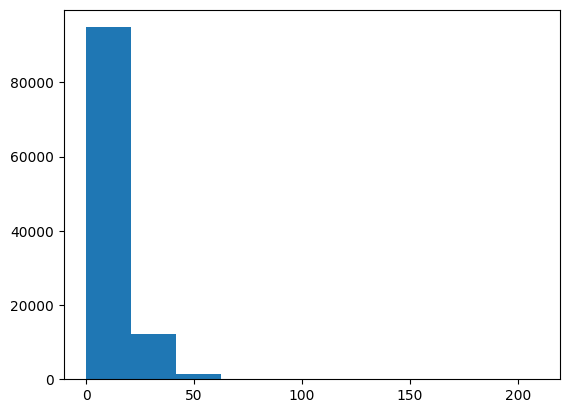

In [70]:
plt.hist(df['delivery_time'])

<Axes: ylabel='delivery_time'>

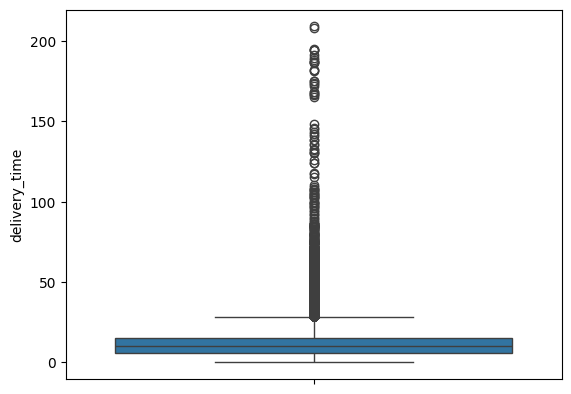

In [71]:
sns.boxplot(df['delivery_time'])

(array([ 5461., 16426., 23928., 19024., 10137., 10829.,  7159.,  4944.,
         3112.,  2142.]),
 array([ 0. ,  2.8,  5.6,  8.4, 11.2, 14. , 16.8, 19.6, 22.4, 25.2, 28. ]),
 <BarContainer object of 10 artists>)

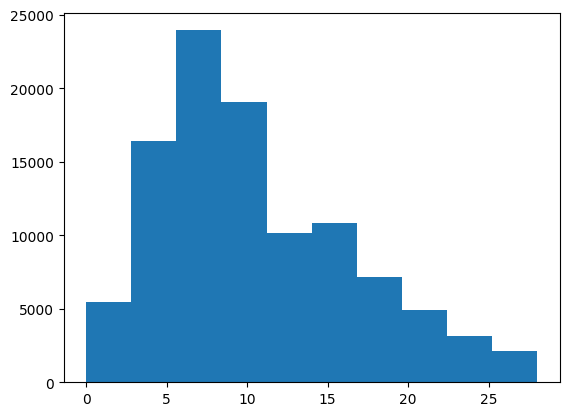

In [72]:
q1 = df['delivery_time'].quantile(0.25)
q3 = df['delivery_time'].quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

df = df[(df['delivery_time'] >= lower_bound) & (df['delivery_time'] <= upper_bound)]

# pós tratamento
plt.hist(df['delivery_time'])

<Axes: ylabel='delivery_time'>

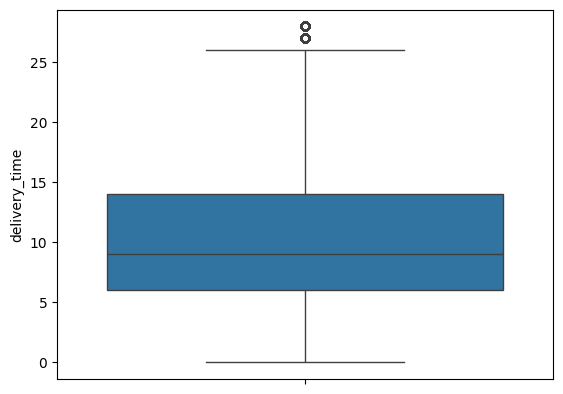

In [73]:
sns.boxplot(df['delivery_time'])

<Axes: ylabel='product_volume_l'>

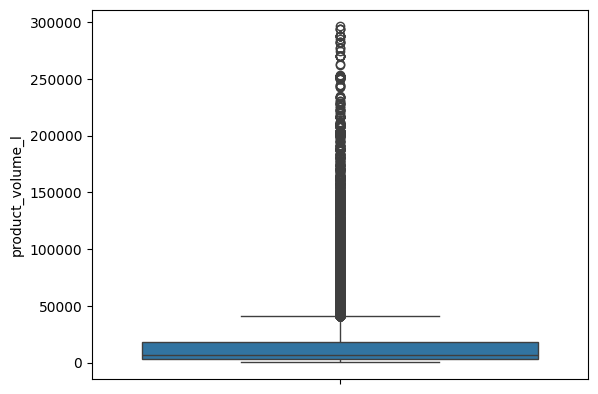

In [74]:
# Target Encoder Manual
df_category_enconded = df.groupby(by='product_category_name')['delivery_time'].median()
df_category_enconded = df_category_enconded.to_frame().reset_index()
df_category_enconded.rename(columns={'delivery_time': 'product_category_name_encoded'}, inplace=True)

df = pd.merge(df, df_category_enconded, how='left', on='product_category_name')

# TODO: Fazer o cálculo do volume dos produtos para uso de features
df['product_volume_l'] = (
    df['product_length_cm'] *
    df['product_height_cm'] *
    df['product_width_cm']
)

sns.boxplot(df['product_volume_l'])

In [75]:
Q1 = df['product_volume_l'].quantile(0.25)
Q3 = df['product_volume_l'].quantile(0.75)
IQR = Q3 - Q1

df = df[(df['product_volume_l'] >= Q1 - 1.5 * IQR) & (df['product_volume_l'] <= Q3 + 1.5 * IQR)]

<Axes: ylabel='product_volume_l'>

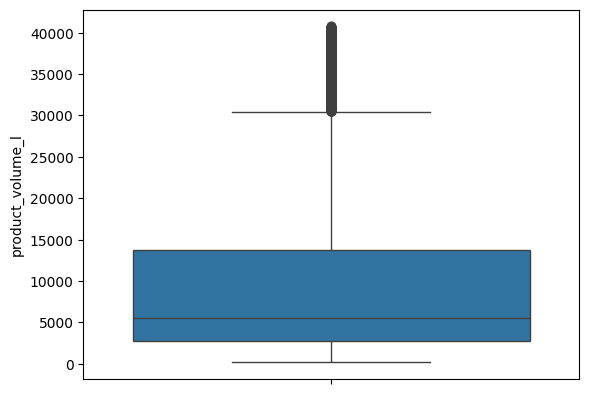

In [76]:
sns.boxplot(df['product_volume_l'])

In [77]:
if not os.path.exists('../datasets/nosso-dataset/dados_tratados.csv'):
    df.to_csv('../datasets/nosso-dataset/dados_tratados.csv', index=False)
else:
    print(f'Arquivo ja criado no diretorio dataset... vai la olhar!')
    pass

df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,customer_lat,customer_lng,seller_lat,seller_lng,distancia_vendedor_cliente_km,flag_mesmo_estado,flag_mesma_cidade,delivery_time,product_category_name_encoded,product_volume_l
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,...,-23.576983,-46.587161,-23.680729,-46.444238,18.566632,1,0,8,8.0,1976.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,...,-12.177924,-44.660711,-19.807681,-43.980427,847.437333,0,0,13,8.0,4693.0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,...,-16.745150,-48.514783,-21.363502,-48.229601,512.100044,0,0,9,9.0,9576.0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977,59296,...,-5.774190,-35.271143,-19.837682,-43.924053,1816.085655,0,0,13,9.0,6000.0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6,9195,...,-23.676370,-46.514627,-23.543395,-46.262086,29.684401,1,0,2,9.0,11475.0
